# Looking at the Dataset distributions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('dataset_catalog.csv')
df.head()

,image_paths,emotion,usage,race,race4,gender,age,augmented
0,FER-Original-Dataset/FER/anger/3975.png,anger,training,White,White,Female,40-49,False
1,FER-Original-Dataset/FER/anger/348.png,anger,training,White,Black,Male,3-9,False
2,FER-Original-Dataset/FER/anger/1804.png,anger,training,White,White,Male,40-49,False
3,FER-Original-Dataset/FER/anger/1810.png,anger,training,White,White,Male,30-39,False
4,FER-Original-Dataset/FER/anger/3961.png,anger,training,White,White,Male,30-39,False


In [6]:
df['usage'].unique()

array(['training', 'fer_validation', 'not used', 'ckp_validation'],
      dtype=object)

In [16]:
df[df['image_paths'] == 'FER-Original-Dataset-Augmented/FER/anger/1_blur.png']

,image_paths,emotion,usage,race,race4,gender,age,augmented
128104,FER-Original-Dataset-Augmented/FER/anger/1_blu...,anger,not used,White,White,Male,30-39,True


In [15]:
df[df['augmented'] == True].head()

,image_paths,emotion,usage,race,race4,gender,age,augmented
20940,FER-Original-Dataset-Augmented/FER/anger/470_s...,anger,not used,Black,Black,Male,30-39,True
20941,FER-Original-Dataset-Augmented/FER/anger/625_r...,anger,not used,White,White,Male,20-29,True
20942,FER-Original-Dataset-Augmented/FER/anger/3491_...,anger,not used,White,White,Male,50-59,True
20943,FER-Original-Dataset-Augmented/FER/anger/62_pe...,anger,not used,White,White,Male,40-49,True
20944,FER-Original-Dataset-Augmented/FER/anger/2341_...,anger,not used,Middle Eastern,Indian,Female,20-29,True


## Distribution of Training and Validation images

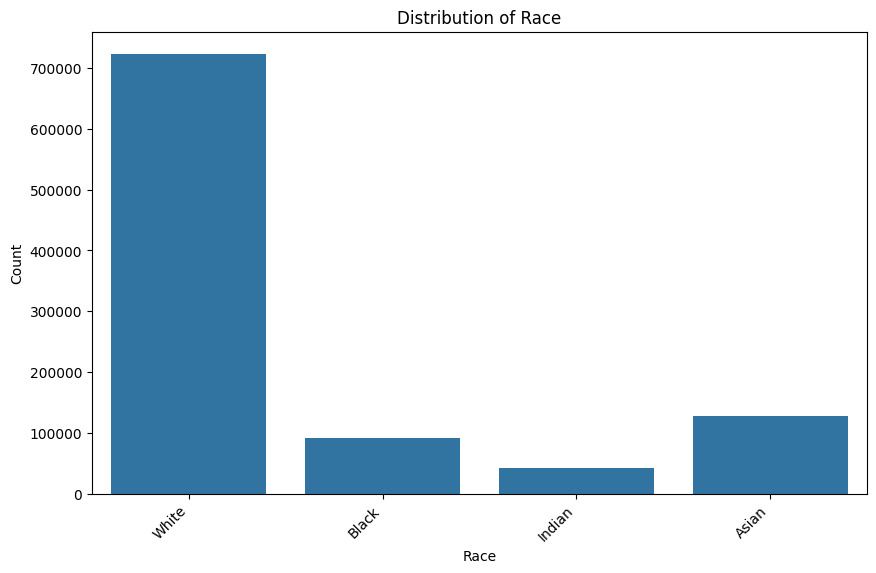

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out 'unclassified' from the 'race4' column
df_race_filtered = df[df['race4'] != 'unclassified']

plt.figure(figsize=(10, 6))
sns.countplot(data=df_race_filtered, x='race4')
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

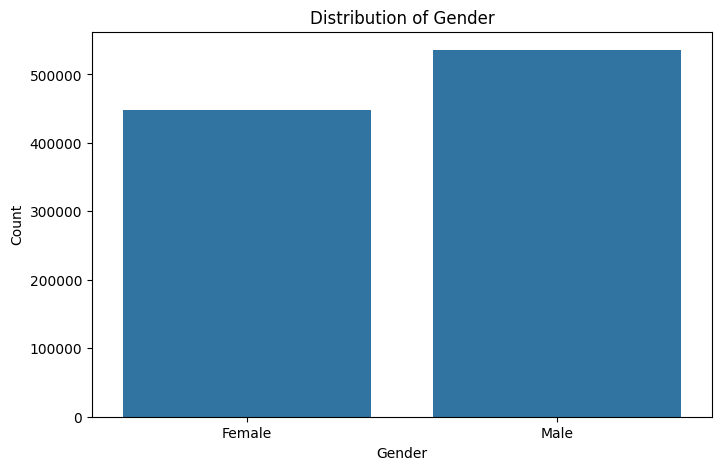

In [23]:
# Filter out 'unclassified' from the 'gender' column
df_gender_filtered = df[df['gender'] != 'unclassified']

plt.figure(figsize=(8, 5))
sns.countplot(data=df_gender_filtered, x='gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

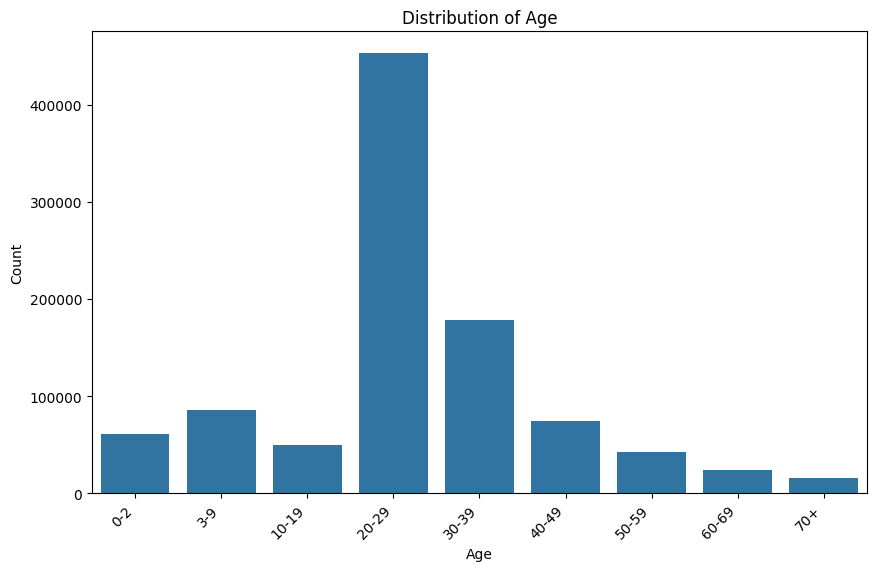

In [26]:
# Filter out 'unclassified' from the 'age' column
df_age_filtered = df[df['age'] != 'unclassified']

plt.figure(figsize=(10, 6))
sns.countplot(data=df_age_filtered, x='age', order=['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+'])
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# Import the BaselineModel

from baseline_framework import BaselineModel
model = BaselineModel()  # Auto-loads model.pth

In [11]:
# Helper function to plot confusion matrix

def plot_confusion_matrix(results, title):
    cm = results['confusion_matrix']
    labels = results['emotion_labels']

    # Normalize the confusion matrix to show relative values
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                            xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [12]:
# Helper function to get image paths by filter

def get_image_paths_by_filter(df, column, value, usage='validation'):
    # Filter the dataframe based on the column and value
    filtered_df = df[df[column] == value]

    # Further filter by usage if specified
    if usage == 'validation':
        # For validation, include both fer_validation and ckp_validation
        filtered_df = filtered_df[filtered_df['usage'].isin(['fer_validation', 'ckp_validation'])]
    elif usage is not None:
        # For any other specified usage, filter by that usage
        filtered_df = filtered_df[filtered_df['usage'] == usage]
    
    # Create the list of image paths, prepending '../../' to each
    image_paths = ['../../' + path for path in filtered_df['image_paths']]
    
    return image_paths

In [13]:
def calculate_equalized_odds(results, group_name):
    cm = results['confusion_matrix']
    labels = results['emotion_labels']
    
    print(f"--- {group_name} ---")
    
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        # True Positive Rate (TPR)
        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        # False Positive Rate (FPR)
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        print(f"  Class: {label}")
        print(f"    True Positive Rate (TPR): {tpr:.4f}")
        print(f"    False Positive Rate (FPR): {fpr:.4f}")
    print("-" * 20)

In [14]:
result = model.predict_image('../../FER-Original-Dataset/FER/calm/1.png')
print(result['emotion'])

fear


## Check Model for Male - Female Fairness

In [9]:
female_image_paths = get_image_paths_by_filter(df, 'gender', 'Female')
male_image_paths = get_image_paths_by_filter(df, 'gender', 'Male')

NameError: name 'get_image_paths_by_filter' is not defined

In [33]:
results_female = model.evaluate_batch(female_image_paths)
print(results_female["accuracy"])

54.761904761904766


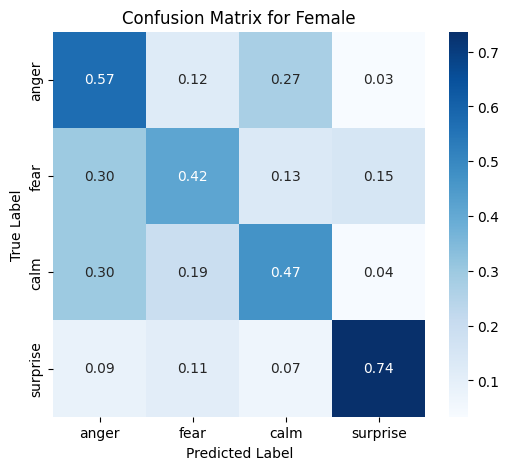

In [34]:
plot_confusion_matrix(results_female, "Confusion Matrix for Female")

54.20716467647876


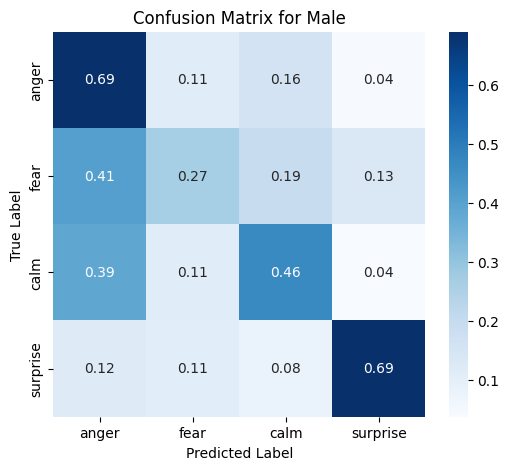

In [35]:
results_male = model.evaluate_batch(male_image_paths)
print(results_male["accuracy"])
plot_confusion_matrix(results_male, "Confusion Matrix for Male")

In [46]:
# Calculate and display Equalized Odds metrics for both groups
print("Equalized Odds (Gender)\n")
calculate_equalized_odds(results_female, "Female")
calculate_equalized_odds(results_male, "Male")

Equalized Odds (Gender)

--- Female ---
  Class: anger
    True Positive Rate (TPR): 0.5699
    False Positive Rate (FPR): 0.2277
  Class: fear
    True Positive Rate (TPR): 0.4153
    False Positive Rate (FPR): 0.1468
  Class: calm
    True Positive Rate (TPR): 0.4700
    False Positive Rate (FPR): 0.1460
  Class: surprise
    True Positive Rate (TPR): 0.7364
    False Positive Rate (FPR): 0.0735
--------------------
--- Male ---
  Class: anger
    True Positive Rate (TPR): 0.6878
    False Positive Rate (FPR): 0.3110
  Class: fear
    True Positive Rate (TPR): 0.2659
    False Positive Rate (FPR): 0.1118
  Class: calm
    True Positive Rate (TPR): 0.4630
    False Positive Rate (FPR): 0.1414
  Class: surprise
    True Positive Rate (TPR): 0.6895
    False Positive Rate (FPR): 0.0597
--------------------


## Check Model for Race Fairness

In [36]:
image_paths_white = get_image_paths_by_filter(df, 'race4', 'White')
image_paths_asian = get_image_paths_by_filter(df, 'race4', 'Asian')
image_paths_black = get_image_paths_by_filter(df, 'race4', 'Black')
image_paths_indian = get_image_paths_by_filter(df, 'race4', 'Indian')
image_paths_none_white = image_paths_asian + image_paths_black + image_paths_indian

53.16908030844461


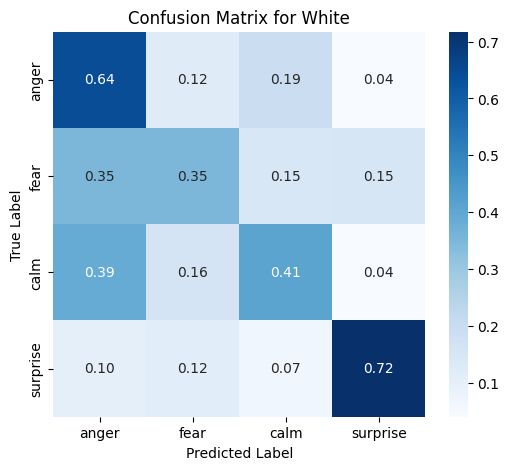

In [37]:
results_white = model.evaluate_batch(image_paths_white)
print(results_white["accuracy"])
plot_confusion_matrix(results_white, "Confusion Matrix for White")

58.333333333333336


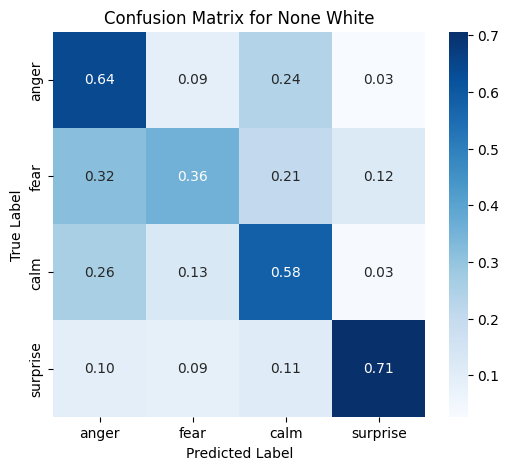

In [38]:
results_none_white = model.evaluate_batch(image_paths_none_white)
print(results_none_white["accuracy"])
plot_confusion_matrix(results_none_white, "Confusion Matrix for None White")

In [47]:
# Calculate and display Equalized Odds metrics
print("Equalized Odds (Race)\n")
calculate_equalized_odds(results_white, "White")
calculate_equalized_odds(results_none_white, "None White")

Equalized Odds (Race)

--- White ---
  Class: anger
    True Positive Rate (TPR): 0.6414
    False Positive Rate (FPR): 0.2802
  Class: fear
    True Positive Rate (TPR): 0.3506
    False Positive Rate (FPR): 0.1352
  Class: calm
    True Positive Rate (TPR): 0.4105
    False Positive Rate (FPR): 0.1319
  Class: surprise
    True Positive Rate (TPR): 0.7175
    False Positive Rate (FPR): 0.0732
--------------------
--- None White ---
  Class: anger
    True Positive Rate (TPR): 0.6422
    False Positive Rate (FPR): 0.2293
  Class: fear
    True Positive Rate (TPR): 0.3586
    False Positive Rate (FPR): 0.1097
  Class: calm
    True Positive Rate (TPR): 0.5790
    False Positive Rate (FPR): 0.1860
  Class: surprise
    True Positive Rate (TPR): 0.7064
    False Positive Rate (FPR): 0.0476
--------------------


57.8005115089514


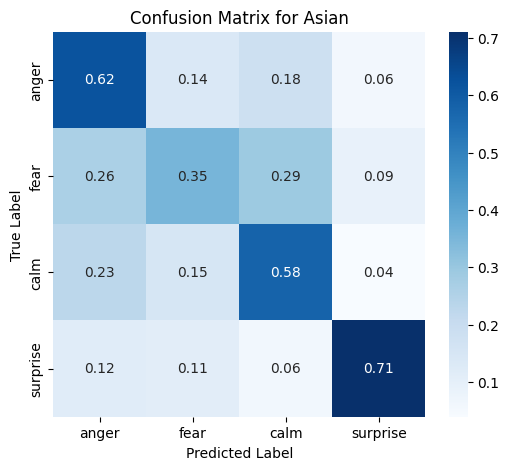

In [50]:
image_paths_asian = model.evaluate_batch(image_paths_asian)
print(image_paths_asian["accuracy"])
plot_confusion_matrix(image_paths_asian, "Confusion Matrix for Asian")

60.54313099041534


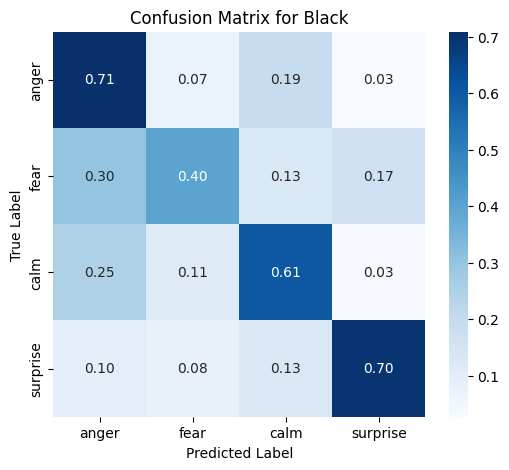

In [51]:
image_paths_black = model.evaluate_batch(image_paths_black)
print(image_paths_black["accuracy"])
plot_confusion_matrix(image_paths_black, "Confusion Matrix for Black")

55.940594059405946


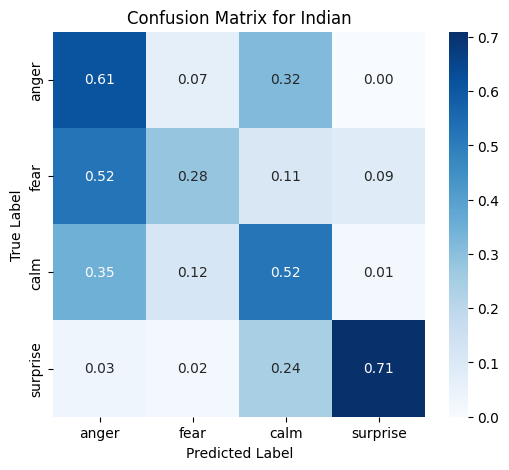

In [52]:
image_paths_indian = model.evaluate_batch(image_paths_indian)
print(image_paths_indian["accuracy"])
plot_confusion_matrix(image_paths_indian, "Confusion Matrix for Indian")

## Check Model for Age Fairness

In [39]:
image_paths_age_young1 = get_image_paths_by_filter(df, 'age', '0-2')
image_paths_age_young2 = get_image_paths_by_filter(df, 'age', '3-9')
image_paths_age_young3 = get_image_paths_by_filter(df, 'age', '10-19')
image_paths_age_young = image_paths_age_young1 + image_paths_age_young2 + image_paths_age_young3

image_paths_age_tweens = get_image_paths_by_filter(df, 'age', '20-29')

image_paths_age_adult1 = get_image_paths_by_filter(df, 'age', '30-39')
image_paths_age_adult2 = get_image_paths_by_filter(df, 'age', '40-49')
image_paths_age_adult3 = get_image_paths_by_filter(df, 'age', '50-59')
image_paths_age_adult = image_paths_age_adult1 + image_paths_age_adult2 + image_paths_age_adult3

image_paths_age_senior1 = get_image_paths_by_filter(df, 'age', '60-69')
image_paths_age_senior2 = get_image_paths_by_filter(df, 'age', '70+')
image_paths_age_senior = image_paths_age_senior1 + image_paths_age_senior2

53.517364203027604


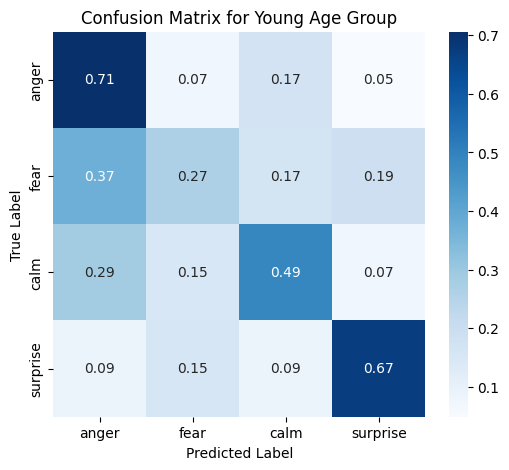

In [40]:
results_young = model.evaluate_batch(image_paths_age_young)
print(results_young["accuracy"])
plot_confusion_matrix(results_young, "Confusion Matrix for Young Age Group")

57.13213213213213


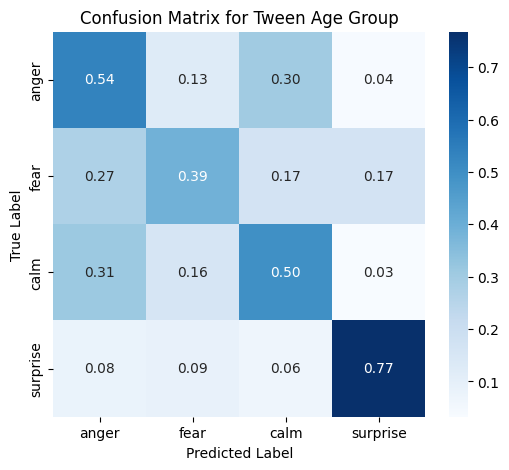

In [41]:
results_tweens = model.evaluate_batch(image_paths_age_tweens)
print(results_tweens["accuracy"])
plot_confusion_matrix(results_tweens, "Confusion Matrix for Tween Age Group")

50.55803571428571


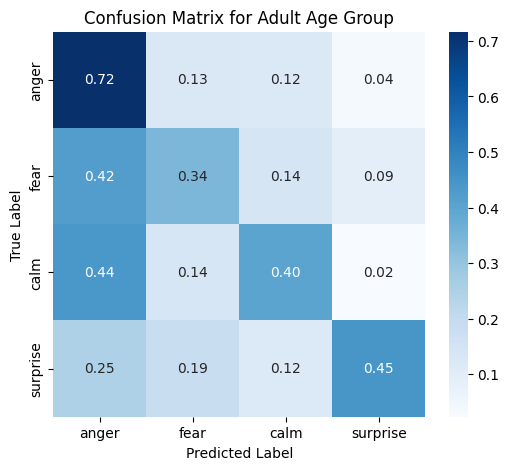

In [42]:
results_adult = model.evaluate_batch(image_paths_age_adult)
print(results_adult["accuracy"])
plot_confusion_matrix(results_adult, "Confusion Matrix for Adult Age Group")

43.11926605504588


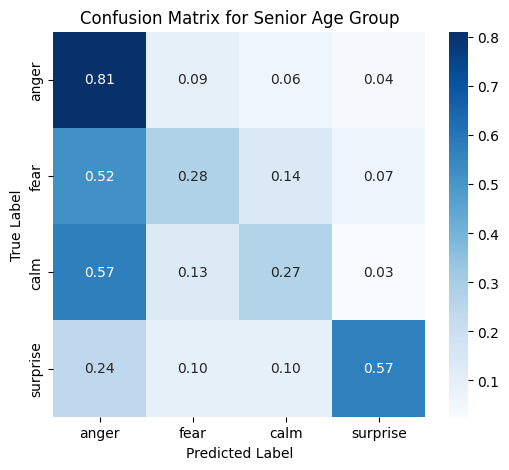

In [43]:
results_senior = model.evaluate_batch(image_paths_age_senior)
print(results_senior["accuracy"])
plot_confusion_matrix(results_senior, "Confusion Matrix for Senior Age Group")

In [49]:
# Calculate and display Equalized Odds metrics
print("Equalized Odds (Age)\n")
calculate_equalized_odds(results_young, "Young")
calculate_equalized_odds(results_tweens, "Tweens")
calculate_equalized_odds(results_adult, "Adult")
calculate_equalized_odds(results_senior, "Senior")

Equalized Odds (Age)

--- Young ---
  Class: anger
    True Positive Rate (TPR): 0.7061
    False Positive Rate (FPR): 0.2483
  Class: fear
    True Positive Rate (TPR): 0.2667
    False Positive Rate (FPR): 0.1314
  Class: calm
    True Positive Rate (TPR): 0.4897
    False Positive Rate (FPR): 0.1401
  Class: surprise
    True Positive Rate (TPR): 0.6717
    False Positive Rate (FPR): 0.0967
--------------------
--- Tweens ---
  Class: anger
    True Positive Rate (TPR): 0.5351
    False Positive Rate (FPR): 0.2144
  Class: fear
    True Positive Rate (TPR): 0.3912
    False Positive Rate (FPR): 0.1244
  Class: calm
    True Positive Rate (TPR): 0.4970
    False Positive Rate (FPR): 0.1540
  Class: surprise
    True Positive Rate (TPR): 0.7678
    False Positive Rate (FPR): 0.0681
--------------------
--- Adult ---
  Class: anger
    True Positive Rate (TPR): 0.7164
    False Positive Rate (FPR): 0.3986
  Class: fear
    True Positive Rate (TPR): 0.3418
    False Positive Rate (FPR):

## Entropy

Average entropy on all validation images: 1.3829
Accuracy on all validation images: 54.14%


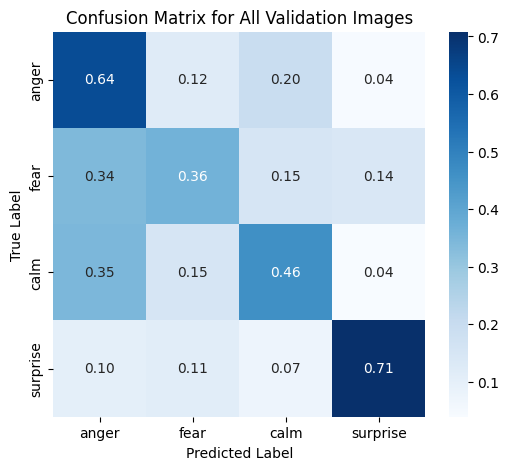

In [15]:
# Get all validation image paths
validation_df = df[df['usage'].isin(['fer_validation', 'ckp_validation'])]
all_validation_image_paths = ['../../' + path for path in validation_df['image_paths']]

# Calculate entropy for the batch of validation images
entropies = model.entropy_batch(all_validation_image_paths)

# Filter out None values (for failed predictions) and calculate the average
if entropies:
    valid_entropies = [e for e in entropies if e is not None]
    if valid_entropies:
        average_entropy = np.mean(valid_entropies)
        print(f"Average entropy on all validation images: {average_entropy:.4f}")
    else:
        print("Could not calculate entropy for any of the validation images.")
else:
    print("Entropy batch calculation failed.")

# Evaluate the model on all validation images to get accuracy and confusion matrix
results_all_validation = model.evaluate_batch(all_validation_image_paths)

# Print accuracy
print(f"Accuracy on all validation images: {results_all_validation['accuracy']:.2f}%")

# Plot the confusion matrix for all validation images
plot_confusion_matrix(results_all_validation, "Confusion Matrix for All Validation Images")

In [16]:
# Count images per racial group in the validation set
print("Racial distribution in the validation set:")
print(validation_df['race4'].value_counts())
print("\n" + "="*30 + "\n")

# Count images per age group in the validation set
print("Age distribution in the validation set:")
print(validation_df['age'].value_counts())

Racial distribution in the validation set:
race4
White           5317
Asian            782
Black            626
unclassified     475
Indian           404
Name: count, dtype: int64


Age distribution in the validation set:
age
20-29           3996
30-39           1179
unclassified     475
3-9              440
40-49            397
10-19            372
0-2              311
50-59            216
60-69            131
70+               87
Name: count, dtype: int64
